In [1]:
import util
import graficos
import func 

In [2]:
import pandas as pd
import numpy as np
from io import StringIO
import astroquery
from astroquery.sdss import SDSS
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.integrate import quad
import matplotlib.patches as patches
import shutil
import zipfile
import os
import imageio
import matplotlib.patches as mpatches
import scipy 


from sklearn.cluster import DBSCAN

pd.set_option('display.max_columns', None)

In [3]:
filtradas_SN2 = pd.read_csv('lineas_filtradas_SN2.csv')
hdelta_hgamma = pd.read_csv('Lineas_extra.csv')
merged_df_filtered_SN2 = pd.merge(filtradas_SN2, hdelta_hgamma, on='specObjId') 

merged_df_filtered_SN2


,targetObjId,specObjId,plateID,targetType,platerun,mjd,fiberId,plate,tile,ra,dec,subClass,rChi2,velDispZ,velDispErr,velDisp,snMedian,snMedian_u,snMedian_g,snMedian_i,snMedian_r,snMedian_z,err_u,err_g,err_r,err_i,err_z,dered_u,dered_g,dered_r,dered_i,dered_z,flags_photo,sciencePrimary,z,zErr,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroFluxIvar_u,petroFluxIvar_g,petroFluxIvar_r,petroFluxIvar_i,petroFluxIvar_z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,modelFluxIvar_u,modelFluxIvar_g,modelFluxIvar_r,modelFluxIvar_i,modelFluxIvar_z,etiqueta,r_comovil,r_err,DM,M_r,M_g,M_r_kcorrect,M_g_kcorrect,kcorrect_r,kcorrect_g,M_r_kcorrect_modelFlux,M_g_kcorrect_modelFlux,kcorrect_r_modelFlux,kcorrect_g_modelFlux,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,oiii_4959_flux_err,oiii_5007_flux,oiii_5007_flux_err,hei_5876_flux,hei_5876_flux_err,oi_6300_flux,oi_6300_flux_err,nii_6548_flux,nii_6548_flux_err,h_alpha_flux,h_alpha_flux_err,nii_6584_flux,nii_6584_flux_err,sii_6717_flux,sii_6717_flux_err,sii_6731_flux,sii_6731_flux_err,reliable_x,color_gr,AGN,AGN_VO87-OI,AGN_BPT-NII,AGN_VO87-SII,h_gamma_flux,h_gamma_flux_err,h_delta_flux,h_delta_flux_err,reliable_y
0,11557302279471150,1890442071513262080,1890385996420245504,SCIENCE,dr2003.12.1,53149,204,1679,1184,232.89301,39.887223,STARBURST,2.759871,0,20.199030,13.20125,20.68994,7.169607,19.48144,23.68311,24.57376,13.48847,0.016954,0.005013,0.004761,0.005174,0.012442,18.11242,17.24763,16.94011,16.75622,16.62669,68988043520,1,0.504029,0.000088,4.263180,44.841240,139.087000,226.722800,322.812000,0.303818,0.211878,0.034586,0.014106,0.006631,6.265040,41.953620,133.619600,218.578400,319.34800,2.703582,6.867417,2.088453,0.906649,0.108131,0,1878.202852,5.004538e-15,36.368712,-20.203112,-19.895592,-48.274387,-47.859370,0.568680,1.382684,-48.221554,-47.678967,0.559387,1.274550,440.78770,10.465620,492.24530,10.658280,7.652645,2.785784,354.00100,5.077673,203.39340,4.324126,616.89440,7.268903,40.588620,2.454408,29.624530,2.094657,57.35492,0.988380,1150.97900,10.251810,172.99570,2.981180,167.65650,3.318313,124.93480,3.357132,1,0.30752,False,False,False,False,162.79920,3.955755,98.145150,3.610141,1
1,11275376875274305,1515512174368286720,1515461321955502080,SCIENCE,dr2003.05.1,52822,185,1346,995,209.70949,41.751296,STARBURST,6.153744,0,21.478930,20.46089,19.66992,6.844073,18.97459,21.65471,22.72266,12.02489,0.014957,0.004230,0.004433,0.004760,0.011518,17.95212,17.03340,16.89958,16.68328,16.61744,35253360132112,1,0.158843,0.000029,0.569889,1.399914,5.545683,16.538250,24.021730,2.760902,11.563000,2.649189,0.874933,0.075430,0.047399,1.490131,5.430546,15.282240,21.14679,14.531430,49.911720,24.450910,9.048003,0.587336,0,640.718723,1.707218e-15,34.033337,-17.908267,-17.774447,-41.819157,-40.645794,0.486002,0.807273,-41.796375,-40.713600,0.486002,0.807273,746.57310,15.900580,876.58120,16.780560,11.569520,3.491089,717.64890,8.856584,657.80630,8.612718,1957.99000,18.503520,88.776520,3.241331,39.250120,2.609964,93.56466,1.517550,2475.86400,19.220480,282.21260,4.577276,261.09410,4.564888,191.74290,3.875889,1,0.13382,False,False,False,False,310.41240,5.949204,164.608100,5.116585,1
2,11557227673288870,1849999284963928064,1849853599673247744,SCIENCE,dr2003.11.3,53143,530,1643,1155,213.91326,37.371322,STARBURST,2.737305,0,14.462620,141.39130,21.10927,6.961064,19.57236,25.76343,25.19413,15.30732,0.018603,0.004356,0.004023,0.004231,0.010717,17.89254,16.98387,16.54391,16.15817,16.05874,217164414976,1,0.658958,0.000201,-4.381327,14.240200,68.500310,126.874100,218.794700,0.163823,0.970092,0.363155,0.162351,0.009918,2.797156,18.480520,82.343360,150.862800,233.39290,1.268823,5.002958,1.660192,0.709704,0.069481,0,2364.547309,6.300420e-15,36.868740,-21.099340,-20.659380,-48.632183,-47.738304,0.993035,1.804596,-48.727867,-47.962000,0.888877,1.745299,389.27280,8.196134,129.11600,6.954089,6.851777,3.297699,322.

In [4]:
agn_subclasses = merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN'] == True, 'subClass']

agn_subclasses.unique()

array(['AGN BROADLINE', 'AGN', 'STARFORMING', 'STARBURST', nan,
       'STARBURST BROADLINE', 'STARFORMING BROADLINE', 'BROADLINE'],
      dtype=object)

## Matrices de cocientes

In [5]:
flux_columns = [
    'oii_3726_flux',  'oii_3729_flux',
    'oiii_4363_flux',  'h_beta_flux', 
    'oiii_4959_flux',  'oiii_5007_flux',
    'hei_5876_flux', 'oi_6300_flux',
    'nii_6548_flux', 'h_alpha_flux',
    'nii_6584_flux', 'sii_6717_flux',
    'sii_6731_flux', 'h_delta_flux',
    'h_gamma_flux']

matrices_SN2 = []

for idx, galaxy in merged_df_filtered_SN2.iterrows():
    
    flux_values = galaxy[flux_columns].values

    #13x13 matrix to store Fi/Fj ratios
    ratio_matrix = np.zeros((len(flux_columns), len(flux_columns)))

    #Fill the matrix
    for i in range(len(flux_columns)):
        for j in range(len(flux_columns)):
            if flux_values[j] != 0:  
                ratio_matrix[i, j] = flux_values[i] / flux_values[j]
            else:
                ratio_matrix[i, j] = np.nan  

    
    matrices_SN2.append(ratio_matrix)

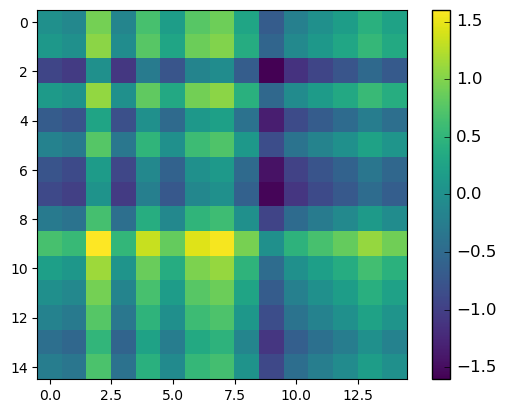

In [6]:

fig = plt.imshow(np.log10(matrices_SN2[10]))
plt.style.use('classic')
plt.colorbar(fig)

In [7]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


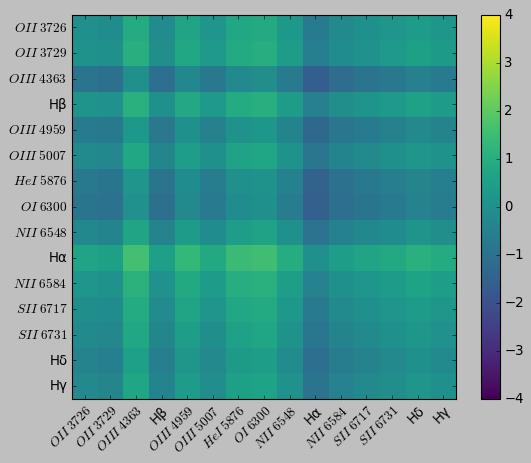

In [8]:
abbreviated_labels = [
    '$OII\\;3726$', '$OII\\;3729$', 
    '$OIII\\;4363$', 'Hβ', 
    '$OIII\\;4959$', '$OIII\\;5007$', 
    '$HeI\\;5876$', '$OI\\;6300$', 
    '$NII\\;6548$', 'Hα', 
    '$NII\\;6584$', '$SII\\;6717$', 
    '$SII\\;6731$', 'Hδ', 'Hγ'
]


fig, ax = plt.subplots()
im = ax.imshow(np.log10(matrices_SN2[10]), cmap='viridis', vmin=-4, vmax=4, interpolation='nearest')

ax.set_xticks(np.arange(len(abbreviated_labels)))
ax.set_yticks(np.arange(len(abbreviated_labels)))
ax.set_xticklabels(abbreviated_labels)
ax.set_yticklabels(abbreviated_labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.style.use('classic')
plt.colorbar(im)

# Mostrar la gráfica
plt.show()


In [9]:
#### VIDEO PARA LAS SN>2 ####
# Ordenar las galaxias por el color (g-r)
"""
merged_df_sorted = merged_df_filtered_SN2.sort_values(by='color_gr')

frames = []

for idx, galaxy in merged_df_sorted.iterrows():
    fig, ax = plt.subplots()
    
    ratio_matrix = matrices_SN2[idx]
    
    im = ax.imshow(np.log10(ratio_matrix), cmap='viridis', vmin=-3, vmax=3)

    ax.set_xticks(np.arange(len(abbreviated_labels)))
    ax.set_yticks(np.arange(len(abbreviated_labels)))
    ax.set_xticklabels(abbreviated_labels)
    ax.set_yticklabels(abbreviated_labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.colorbar(im)

    # Resaltar los ratios seleccionados
    for line1, line2 in ratios_to_highlight:
        i = line_dict[line1]
        j = line_dict[line2]
        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

    # Guardar el frame como imagen
    frame_filename = f'frame_{idx}.png'
    plt.savefig(frame_filename)
    frames.append(frame_filename)
    
    plt.close()

# Crear el video con las imágenes
with imageio.get_writer('galaxies_video_SN2.mp4', format='mp4', fps=2) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)"""

'\nmerged_df_sorted = merged_df_filtered_SN2.sort_values(by=\'color_gr\')\n\nframes = []\n\nfor idx, galaxy in merged_df_sorted.iterrows():\n    fig, ax = plt.subplots()\n    \n    ratio_matrix = matrices_SN2[idx]\n    \n    im = ax.imshow(np.log10(ratio_matrix), cmap=\'viridis\', vmin=-3, vmax=3)\n\n    ax.set_xticks(np.arange(len(abbreviated_labels)))\n    ax.set_yticks(np.arange(len(abbreviated_labels)))\n    ax.set_xticklabels(abbreviated_labels)\n    ax.set_yticklabels(abbreviated_labels)\n\n    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")\n    plt.colorbar(im)\n\n    # Resaltar los ratios seleccionados\n    for line1, line2 in ratios_to_highlight:\n        i = line_dict[line1]\n        j = line_dict[line2]\n        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor=\'black\', facecolor=\'none\')\n        ax.add_patch(rect)\n\n    # Guardar el frame como imagen\n    frame_filename = f\'frame_{idx}.png\'\n    plt.savefig(frame_f

In [10]:
### Guardar frames en una carpeta aparte comprimida: SN > 2
"""
# Crear una carpeta para almacenar los frames
frames_folder = 'video_frames_SN2'
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

# Mover los frames generados a la carpeta
for frame in frames:
    shutil.move(frame, os.path.join(frames_folder, frame))

# Crear un archivo .zip que contenga los frames
zip_filename = 'video_frames_SN2.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(frames_folder):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print(f'Frames comprimidos en {zip_filename}')"""

"\n# Crear una carpeta para almacenar los frames\nframes_folder = 'video_frames_SN2'\nif not os.path.exists(frames_folder):\n    os.makedirs(frames_folder)\n\n# Mover los frames generados a la carpeta\nfor frame in frames:\n    shutil.move(frame, os.path.join(frames_folder, frame))\n\n# Crear un archivo .zip que contenga los frames\nzip_filename = 'video_frames_SN2.zip'\nwith zipfile.ZipFile(zip_filename, 'w') as zipf:\n    for root, dirs, files in os.walk(frames_folder):\n        for file in files:\n            zipf.write(os.path.join(root, file), arcname=file)\n\nprint(f'Frames comprimidos en {zip_filename}')"

In [11]:
### Guardar cocientes en .csv para SN > 2

abbreviated_labels = [
    'OII 3726', 'OII 3729', 
    'OIII 4363', 'Hβ', 
    'OIII 4959', 'OIII 5007', 
    'HeI 5876', 'OI 6300', 
    'NII 6548', 'Hα', 
    'NII 6584', 'SII 6717', 
    'SII 6731', 'Hδ', 'Hγ'
]

galaxy_data = []

# Iterar sobre las galaxias y las matrices de cocientes
for idx, galaxy in merged_df_filtered_SN2.iterrows():
    
    #matriz de cocientes de la galaxia
    ratio_matrix = matrices_SN2[idx]

    #índices de la triangular inferior, sin la diagonal
    tri_lower_indices = np.tril_indices(len(flux_columns), k=-1)

    tri_lower_values = ratio_matrix[tri_lower_indices]
    
    galaxy_info = {
        'specObjId': galaxy['specObjId'],
        'color_gr': galaxy['color_gr'],  
        'M_r': galaxy['M_r'], 
        'z': galaxy['z'],
        'AGN_Kewley': galaxy['AGN'],
        'AGN_VO87-OI':galaxy['AGN_VO87-OI'],
        'AGN_BPT-NII': galaxy['AGN_BPT-NII'],
        'AGN_VO87-SII': galaxy['AGN_VO87-SII']
    }
    
    for i, value in enumerate(tri_lower_values):
        galaxy_info[f'ratio_{abbreviated_labels[tri_lower_indices[0][i]]}/{abbreviated_labels[tri_lower_indices[1][i]]}'] = value
    
    galaxy_data.append(galaxy_info)

df_galaxies_SN2 = pd.DataFrame(galaxy_data)

#df_galaxies_SN2.to_csv('ratios_SN2.csv', index=False)


In [12]:
df_galaxies_SN2

,specObjId,color_gr,M_r,z,AGN_Kewley,AGN_VO87-OI,AGN_BPT-NII,AGN_VO87-SII,ratio_OII 3729/OII 3726,ratio_OIII 4363/OII 3726,ratio_OIII 4363/OII 3729,ratio_Hβ/OII 3726,ratio_Hβ/OII 3729,ratio_Hβ/OIII 4363,ratio_OIII 4959/OII 3726,ratio_OIII 4959/OII 3729,ratio_OIII 4959/OIII 4363,ratio_OIII 4959/Hβ,ratio_OIII 5007/OII 3726,ratio_OIII 5007/OII 3729,ratio_OIII 5007/OIII 4363,ratio_OIII 5007/Hβ,ratio_OIII 5007/OIII 4959,ratio_HeI 5876/OII 3726,ratio_HeI 5876/OII 3729,ratio_HeI 5876/OIII 4363,ratio_HeI 5876/Hβ,ratio_HeI 5876/OIII 4959,ratio_HeI 5876/OIII 5007,ratio_OI 6300/OII 3726,ratio_OI 6300/OII 3729,ratio_OI 6300/OIII 4363,ratio_OI 6300/Hβ,ratio_OI 6300/OIII 4959,ratio_OI 6300/OIII 5007,ratio_OI 6300/HeI 5876,ratio_NII 6548/OII 3726,ratio_NII 6548/OII 3729,ratio_NII 6548/OIII 4363,ratio_NII 6548/Hβ,ratio_NII 6548/OIII 4959,ratio_NII 6548/OIII 5007,ratio_NII 6548/HeI 5876,ratio_NII 6548/OI 6300,ratio_Hα/OII 3726,ratio_Hα/OII 3729,ratio_Hα/OIII 4363,ratio_Hα/Hβ,ratio_Hα/OIII 4959,ratio_Hα/OIII 5007,ratio_Hα/HeI 5876,ratio_Hα/OI 6300,ratio_Hα/NII 6548,ratio_NII 6584/OII 3726,ratio_NII 6584/OII 3729,ratio_NII 6584/OIII 4363,ratio_NII 6584/Hβ,ratio_NII 6584/OIII 4959,ratio_NII 6584/OIII 5007,ratio_NII 6584/HeI 5876,ratio_NII 6584/OI 6300,ratio_NII 6584/NII 6548,ratio_NII 6584/Hα,ratio_SII 6717/OII 3726,ratio_SII 6717/OII 3729,ratio_SII 6717/OIII 4363,ratio_SII 6717/Hβ,ratio_SII 6717/OIII 4959,ratio_SII 6717/OIII 5007,ratio_SII 6717/HeI 5876,ratio_SII 6717/OI 6300,ratio_SII 6717/NII 6548,ratio_SII 6717/Hα,ratio_SII 6717/NII 6584,ratio_SII 6731/OII 3726,ratio_SII 6731/OII 3729,ratio_SII 6731/OIII 4363,ratio_SII 6731/Hβ,ratio_SII 6731/OIII 4959,ratio_SII 6731/OIII 5007,ratio_SII 6731/HeI 5876,ratio_SII 6731/OI 6300,ratio_SII 6731/NII 6548,ratio_SII 6731/Hα,ratio_SII 6731/NII 6584,ratio_SII 6731/SII 6717,ratio_Hδ/OII 3726,ratio_Hδ/OII 3729,ratio_Hδ/OIII 4363,ratio_Hδ/Hβ,ratio_Hδ/OIII 4959,ratio_Hδ/OIII 5007,ratio_Hδ/HeI 5876,ratio_Hδ/OI 6300,ratio_Hδ/NII 6548,ratio_Hδ/Hα,ratio_Hδ/NII 6584,ratio_Hδ/SII 6717,ratio_Hδ/SII 6731,ratio_Hγ/OII 3726,ratio_Hγ/OII 3729,ratio_Hγ/OIII 4363,ratio_Hγ/Hβ,ratio_Hγ/OIII 4959,ratio_Hγ/OIII 5007,ratio_Hγ/HeI 5876,ratio_Hγ/OI 6300,ratio_Hγ/NII 6548,ratio_Hγ/Hα,ratio_Hγ/NII 6584,ratio_Hγ/SII 6717,ratio_Hγ/SII 6731,ratio_Hγ/Hδ
0,1890442071513262080,0.30752,-20.203112,0.504029,False,False,False,False,1.116740,0.017361,0.015546,0.803110,0.719156,46.258647,0.461432,0.413195,26.578183,0.574556,1.399527,1.253226,80.611919,1.742635,3.033011,0.092082,0.082456,5.303868,0.114657,0.199557,0.065795,0.067208,0.060182,3.871149,0.083685,0.145651,0.048022,0.729873,0.130119,0.116517,7.494784,0.162019,0.281990,0.092974,1.413079,1.936062,2.611187,2.338222,150.402769,3.251344,5.658881,1.865763,28.357185,38.852228,20.067659,0.392469,0.351442,22.606001,0.488687,0.850547,0.280430,4.262173,5.839610,3.016231,0.150303,0.380357,0.340595,21.908308,0.473605,0.824297,0.271775,4.130628,5.659381,2.923141,0.145664,0.969137,0.283435,0.253806,16.325702,0.352922,0.614252,0.202522,3.078075,4.217275,2.178275,0.108547,0.722184,0.745183,0.222659,0.199383,12.824997,0.277245,0.482539,0.159096,2.418046,3.312969,1.711190,0.085271,0.567327,0.585394,0.785571,0.369337,0.330728,21.273586,0.459883,0.800415,0.263901,4.010957,5.495419,2.838452,0.141444,0.941059,0.971028,1.303073,1.658760
1,1515512174368286720,0.13382,-17.908267,0.158843,False,False,False,False,1.174140,0.015497,0.013198,0.961257,0.818691,62.029272,0.881101,0.750423,56.856836,0.916613,2.622637,2.233666,169.236926,2.728340,2.976545,0.118912,0.101276,7.673311,0.123705,0.134958,0.045341,0.052574,0.044776,3.392545,0.054693,0.059668,0.020046,0.442123,0.125326,0.106738,8.087169,0.130377,0.142237,0.047786,1.053935,2.383806,3.316305,2.824455,213.998852,3.449966,3.763819,1.264493,27.888726,63.079145,26.461529,0.378011,0.321947,24.392767,0.393246,0.429021,0.144134,3.178910,7.190108,3.016231,0.113986,0.349723,0.297855,22.567410,0.363819,0.396916,0.133348,2.941027,6.652059,2.790520,0.105456,0.925168,0.2

/var/folders/0s/_xxgbjs554192y_2w2mspv3c0000gn/T/ipykernel_3125/2907861969.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


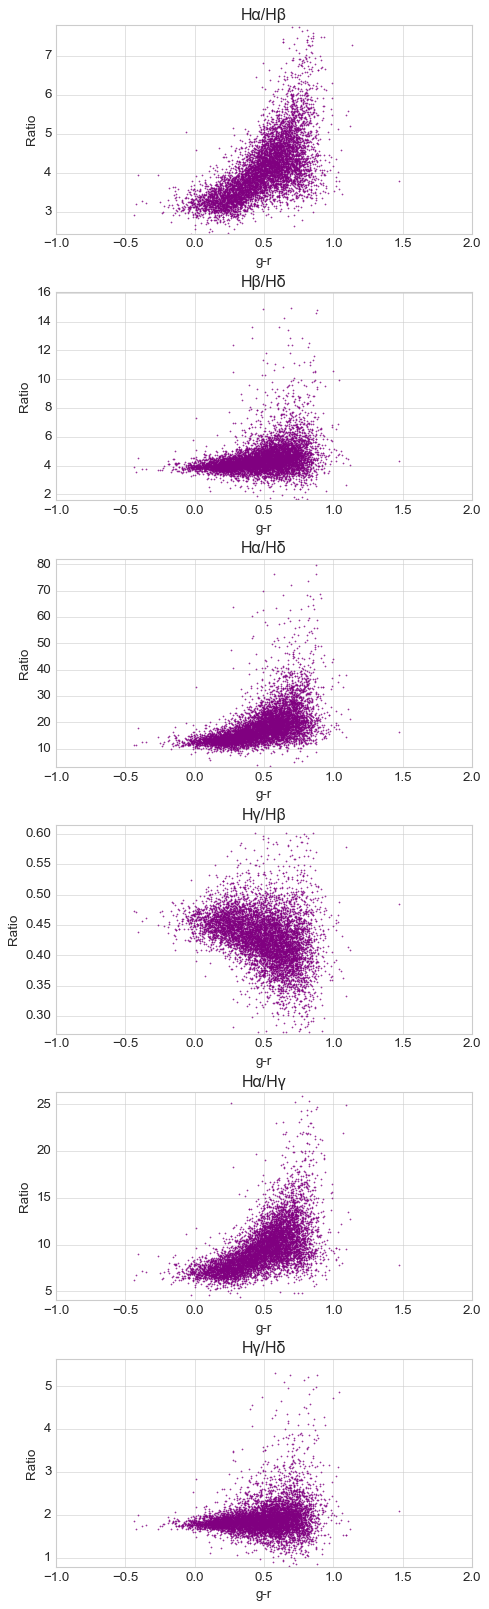

In [185]:
fig, axs = plt.subplots(6, 1, figsize=(6, 20), constrained_layout=True)

# Color x-axis
x_1 = df_galaxies_SN2['color_gr'] 

# List of y-axis variables and titles
y_variables = [
    ('ratio_Hα/Hβ', 'Hα/Hβ', False),
    ('ratio_Hδ/Hβ', 'Hβ/Hδ', True),  # Inverted
    ('ratio_Hδ/Hα', 'Hα/Hδ', True),  # Inverted
    ('ratio_Hγ/Hβ', 'Hγ/Hβ', False),
    ('ratio_Hγ/Hα', 'Hα/Hγ', True),  # Inverted
    ('ratio_Hγ/Hδ', 'Hγ/Hδ', False)
]


for i, (y_var, title, invert) in enumerate(y_variables):
    y_data = df_galaxies_SN2[y_var]
    if invert:
        y_data = y_data**(-1)  # Apply inversion

    # Compute 5th and 95th percentiles (ignoring NaN values)
    p5, p95 = np.nanpercentile(y_data, [1, 99.5])

    axs[i].scatter(x_1, y_data, s=0.2, color='purple')
    axs[i].set_title(title)
    axs[i].set_ylim(p5 - 0.1 * (p95 - p5), p95 + 0.1 * (p95 - p5))  # Extend limits slightly

for ax in axs:
    ax.set_xlabel('g-r')
    ax.set_ylabel('Ratio')

plt.style.use('seaborn-whitegrid')
plt.show()



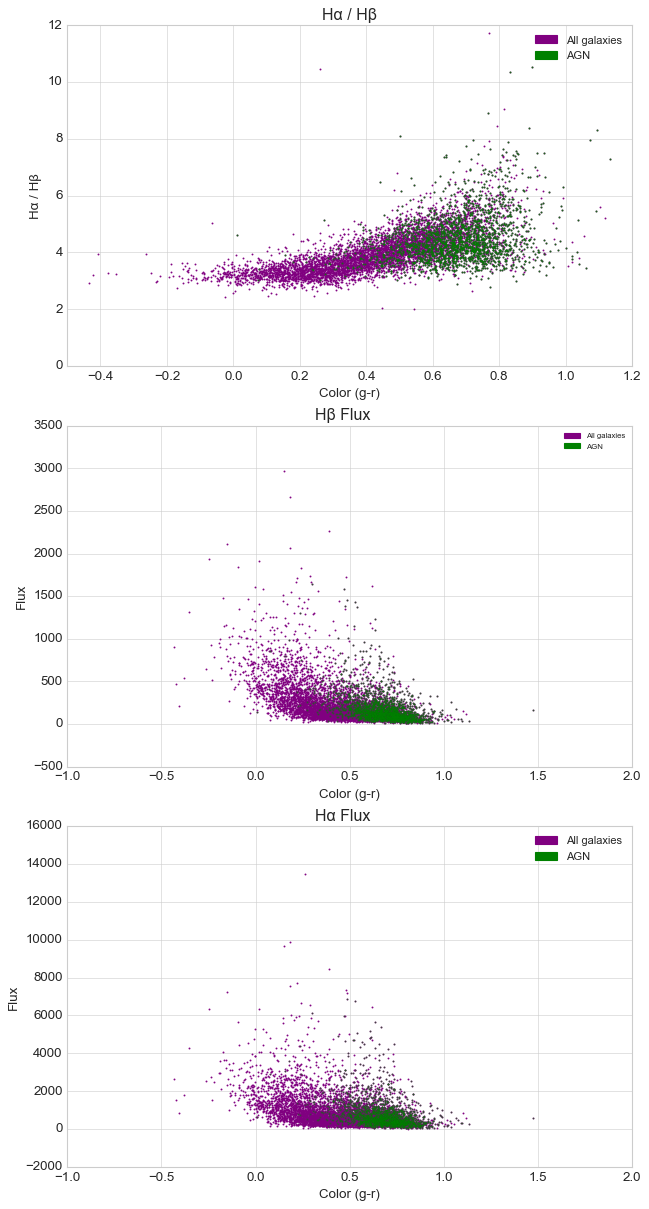

In [200]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15), constrained_layout=True)  

#Hα / Hβ
axs[0].scatter(df_galaxies_SN2['color_gr'], df_galaxies_SN2['ratio_Hα/Hβ'], s=0.5, color='purple', label='All galaxies')
axs[0].scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hα/Hβ'], 
            s=0.8, alpha=0.6, color='green', label='AGN') #Galaxias con AGNs
axs[0].set_title('Hα / Hβ')
axs[0].set_ylim(0, 12)
axs[0].set_xlim(-0.5, 1.2)
axs[0].set_xlabel('Color (g-r)')
axs[0].set_ylabel('Hα / Hβ')

handles, labels = axs[0].get_legend_handles_labels() #Para leyenda mejor ajustada
legend_handles = [mpatches.Patch(color='purple', label='All galaxies'),
                   mpatches.Patch(color='green', label='AGN')]

axs[0].legend(handles=legend_handles, loc='upper right', prop={'size': 10}, scatterpoints=1)

#Hα flujo
axs[1].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_beta_flux'], s=0.5, color='purple', label='All galaxies')
axs[1].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_beta_flux'], 
            s=0.8, alpha=0.4, color='green', label='AGN')
axs[1].set_title('Hβ Flux   ')
axs[1].set_xlabel('Color (g-r)')
axs[1].set_ylabel('Flux')
axs[1].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

#Hα flujo
axs[2].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_alpha_flux'], s=0.5, color='purple', label='All galaxies')
axs[2].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_alpha_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[2].set_title('Hα Flux   ')
axs[2].set_xlabel('Color (g-r)')
axs[2].set_ylabel('Flux')
axs[2].legend(handles=legend_handles, loc='upper right', prop={'size': 10}, scatterpoints=1)


plt.show()


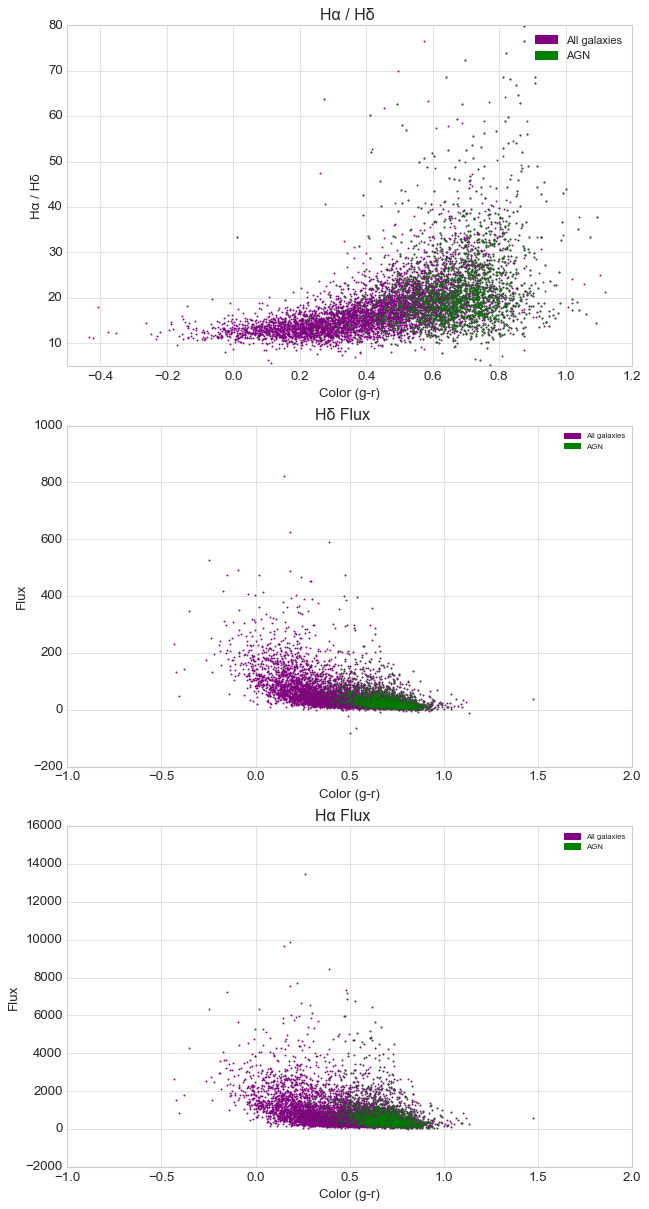

In [202]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15), constrained_layout=True)  

#Hα / Hδ
axs[0].scatter(df_galaxies_SN2['color_gr'], df_galaxies_SN2['ratio_Hδ/Hα']**(-1), s=0.5, color='purple', label='All galaxies')
axs[0].scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hδ/Hα']**(-1), 
            s=0.8, alpha=0.6, color='green', label='AGN') #Galaxias con AGNs
axs[0].set_title('Hα / Hδ ')
axs[0].set_ylim(5, 80)
axs[0].set_xlim(-0.5, 1.2)
axs[0].set_xlabel('Color (g-r)')
axs[0].set_ylabel('Hα / Hδ')

handles, labels = axs[0].get_legend_handles_labels() #Para leyenda mejor ajustada
legend_handles = [mpatches.Patch(color='purple', label='All galaxies'),
                   mpatches.Patch(color='green', label='AGN')]

axs[0].legend(handles=legend_handles, loc='upper right', prop={'size': 10}, scatterpoints=1)

#Hdelta flujo
axs[1].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_delta_flux'], s=0.5, color='purple', label='All galaxies')
axs[1].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_delta_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[1].set_title('Hδ Flux   ')
axs[1].set_xlabel('Color (g-r)')
axs[1].set_ylabel('Flux')
axs[1].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

#Hα flujo
axs[2].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_alpha_flux'], s=0.5, color='purple', label='All galaxies')
axs[2].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_alpha_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[2].set_title('Hα Flux   ')
axs[2].set_xlabel('Color (g-r)')
axs[2].set_ylabel('Flux')
axs[2].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)


plt.show()

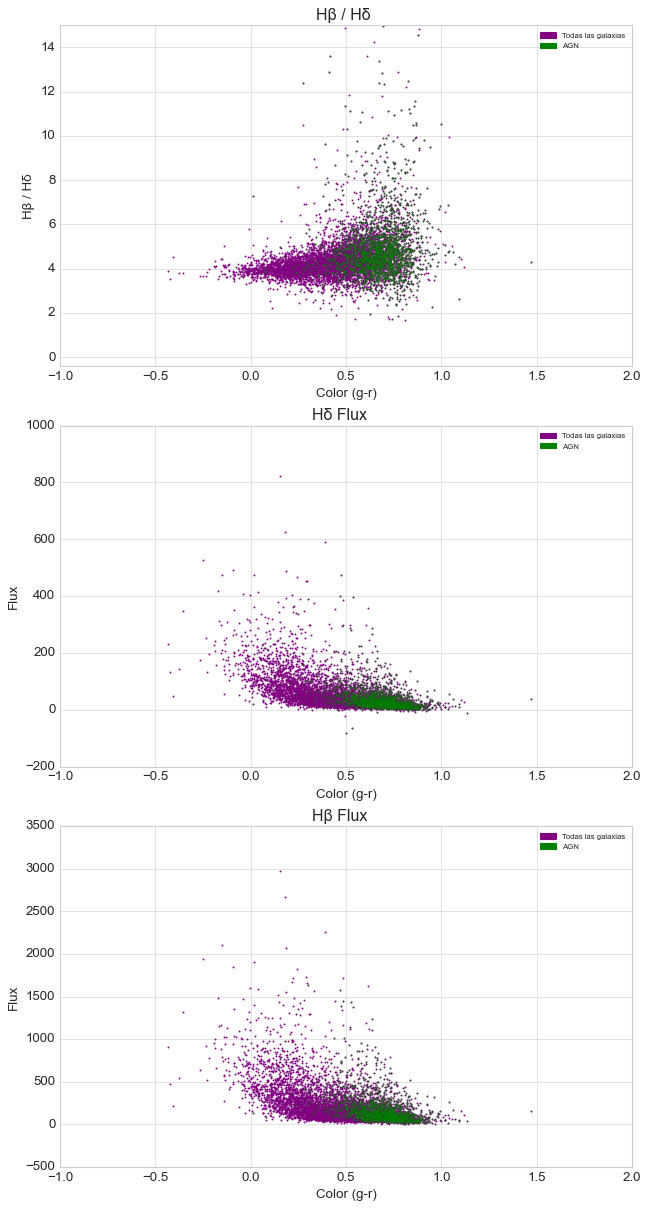

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15), constrained_layout=True)  

#Hβ / Hδ
axs[0].scatter(df_galaxies_SN2['color_gr'], df_galaxies_SN2['ratio_Hδ/Hβ']**(-1), s=0.5, color='purple', label='Todas las galaxias')
axs[0].scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hδ/Hβ']**(-1), 
            s=0.5, alpha=0.6, color='green', label='AGN') #Galaxias con AGNs
axs[0].set_title('Hβ / Hδ ')
axs[0].set_ylim(-0.4, 15)
axs[0].set_xlabel('Color (g-r)')
axs[0].set_ylabel('Hβ / Hδ')

handles, labels = axs[0].get_legend_handles_labels() #Para leyenda mejor ajustada
legend_handles = [mpatches.Patch(color='purple', label='Todas las galaxias'),
                   mpatches.Patch(color='green', label='AGN')]

axs[0].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

#Hdelta flujo
axs[1].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_delta_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[1].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_delta_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[1].set_title('Hδ Flux   ')
axs[1].set_xlabel('Color (g-r)')
axs[1].set_ylabel('Flux')
axs[1].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

#Hβ flujo
axs[2].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_beta_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[2].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_beta_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[2].set_title('Hβ Flux   ')
axs[2].set_xlabel('Color (g-r)')
axs[2].set_ylabel('Flux')
axs[2].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)


plt.show()

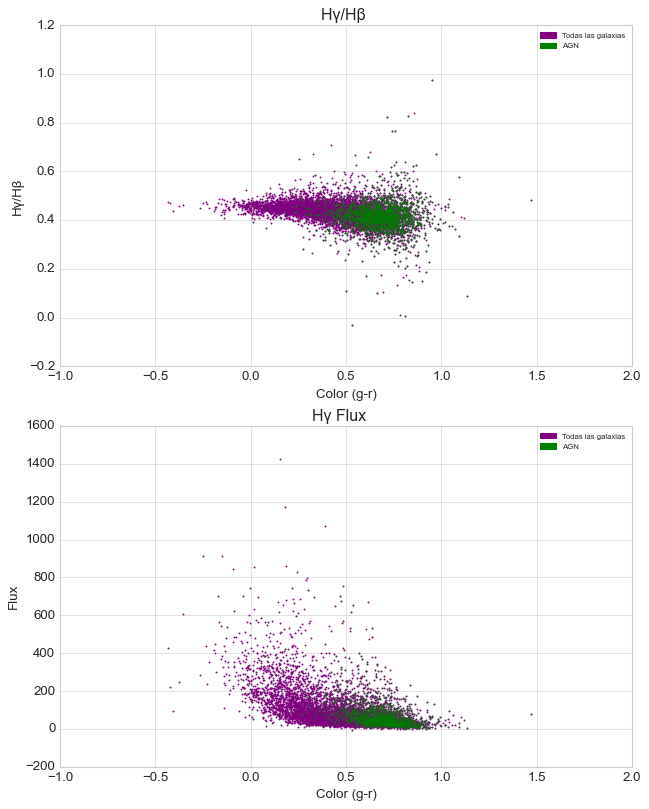

In [54]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)  

#Hβ/Hγ
axs[0].scatter(df_galaxies_SN2['color_gr'], (df_galaxies_SN2['ratio_Hγ/Hβ']), s=0.5, color='purple', label='Todas las galaxias')
axs[0].scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hγ/Hβ'], 
            s=0.5, alpha=0.6, color='green', label='AGN') #Galaxias con AGNs
axs[0].set_title('Hγ/Hβ ')
#axs[0].set_ylim(-0.4, 5)
axs[0].set_xlabel('Color (g-r)')
axs[0].set_ylabel('Hγ/Hβ')

handles, labels = axs[0].get_legend_handles_labels() #Para leyenda mejor ajustada
legend_handles = [mpatches.Patch(color='purple', label='Todas las galaxias'),
                   mpatches.Patch(color='green', label='AGN')]

axs[0].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

#Hgamma flujo
axs[1].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_gamma_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[1].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_gamma_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[1].set_title('Hγ Flux   ')
axs[1].set_xlabel('Color (g-r)')
axs[1].set_ylabel('Flux')
axs[1].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)

"""
#Hβ flujo
axs[2].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_beta_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[2].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_beta_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[2].set_title('Hβ Flux   ')
axs[2].set_xlabel('Color (g-r)')
axs[2].set_ylabel('Flux')
axs[2].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)
"""

plt.show()

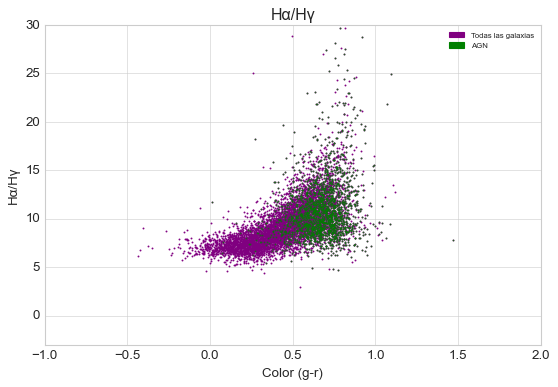

In [18]:
plt.figure(figsize=(8, 5))
plt.scatter(df_galaxies_SN2['color_gr'], df_galaxies_SN2['ratio_Hγ/Hα']**(-1), 
            s=0.5, color='purple', label='Todas las galaxias')
plt.scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hγ/Hα']**(-1), 
            s=0.5, alpha=0.6, color='green', label='AGN')
plt.title('Hα/Hγ')
plt.xlabel('Color (g-r)')
plt.ylabel('Hα/Hγ')
plt.ylim(-3,30)

legend_handles = [mpatches.Patch(color='purple', label='Todas las galaxias'),
                  mpatches.Patch(color='green', label='AGN')]
plt.legend(handles=legend_handles, loc='upper right', prop={'size': 7})

plt.show()
"""
#Hgamma flujo
axs[1].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_gamma_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[1].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_gamma_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[1].set_title('Hγ Flux   ')
axs[1].set_xlabel('Color (g-r)')
axs[1].set_ylabel('Flux')
axs[1].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)


#Hβ flujo
axs[2].scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['h_beta_flux'], s=0.5, color='purple', label='Todas las galaxias')
axs[2].scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'h_beta_flux'], 
            s=0.5, alpha=0.4, color='green', label='AGN')
axs[2].set_title('Hβ Flux   ')
axs[2].set_xlabel('Color (g-r)')
axs[2].set_ylabel('Flux')
axs[2].legend(handles=legend_handles, loc='upper right', prop={'size': 7}, scatterpoints=1)
"""

plt.show()

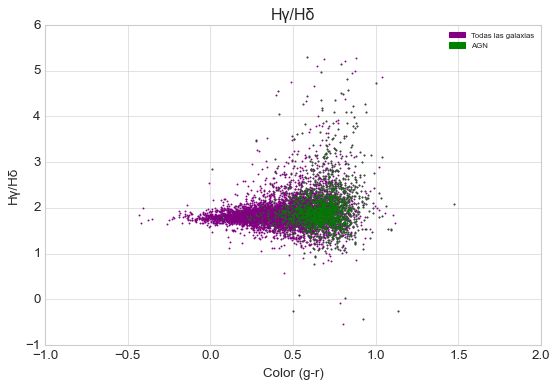

In [19]:
#Hγ/Hδ
plt.figure(figsize=(8, 5))
plt.scatter(df_galaxies_SN2['color_gr'], df_galaxies_SN2['ratio_Hγ/Hδ'], 
            s=0.5, color='purple', label='Todas las galaxias')
plt.scatter(df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            df_galaxies_SN2.loc[df_galaxies_SN2['AGN_BPT-NII'] == True, 'ratio_Hγ/Hδ'], 
            s=0.5, alpha=0.6, color='green', label='AGN')
plt.title('Hγ/Hδ')
plt.xlabel('Color (g-r)')
plt.ylabel('Hγ/Hδ')
plt.ylim(-1, 6)

legend_handles = [mpatches.Patch(color='purple', label='Todas las galaxias'),
                  mpatches.Patch(color='green', label='AGN')]
plt.legend(handles=legend_handles, loc='upper right', prop={'size': 7})

plt.show()


# Corrección por dust extinction 

In [220]:
def correct(f_alpha, f_beta, galaxy_type='Normal'):
    
    """if galaxy_type == 'AGN':
        c = 3.1*(np.log10(f_alpha/f_beta) - np.log10(3.1))
    else:
        c = 3.1*(np.log10(f_alpha/f_beta) - np.log10(2.78))
    """
    c = 3.1*(np.log10(f_alpha/f_beta) - np.log10(2.78))
    return c


#Whitford reddening curve values for Balmer lines
whitford_f_lambda = {
    'h_alpha': 0.666,
    'h_beta': 1.0, 
    'h_gamma': 1.151,
    'h_delta': 1.220
}


def Intrinsec_flux(F_obs, C, line_name):
    """
    Corrects the observed flux for reddening using the Whitford reddening curve.
    
    Parameters:
        F_obs (float or array): Observed flux.
        C (float): Extinction coefficient.
        line_name (str): Name of the Balmer line ('h_alpha', 'h_beta', 'h_gamma', 'h_delta').

    Returns:
        float or array: Intrinsic (de-reddened) flux.
    """
    f_lambda = whitford_f_lambda.get(line_name, None)
    
    if f_lambda is None:
        raise ValueError("Balmer lines only: 'h_alpha', 'h_beta', 'h_gamma', 'h_delta'")
    
    #F_int = F_obs * 10**(C * f_lambda)
    F_int = np.log10(F_obs) + C*f_lambda
    #print(C)
    return  F_int #C*f_lambda #F_int



In [221]:
merged_df_filtered_SN2['c_extinct'] = merged_df_filtered_SN2.apply(
    lambda row: correct(row['h_alpha_flux'], row['h_beta_flux'], 
                        galaxy_type='AGN' if row['AGN_BPT-NII'] else 'Normal'),
    axis=1
)

for line in ['h_alpha', 'h_beta', 'h_gamma', 'h_delta']:
    #merged_df_filtered_SN2[f'{line}_flux_int'] = merged_df_filtered_SN2.apply(
        #lambda row: Intrinsec_flux(row[f'{line}_flux'], row['c_extinct'], line),
        #axis=1
    #)
    merged_df_filtered_SN2[f'{line}_flux_int'] = Intrinsec_flux(merged_df_filtered_SN2[f'{line}_flux'], merged_df_filtered_SN2['c_extinct'], line)

merged_df_filtered_SN2['ratio_Hα/Hβ_corrected'] = 10**merged_df_filtered_SN2['h_alpha_flux_int'] / 10**merged_df_filtered_SN2['h_beta_flux_int']
merged_df_filtered_SN2['ratio_Hα/Hγ_corrected'] = 10**merged_df_filtered_SN2['h_alpha_flux_int'] / 10**merged_df_filtered_SN2['h_gamma_flux_int']
merged_df_filtered_SN2['ratio_Hα/Hδ_corrected'] = 10**merged_df_filtered_SN2['h_alpha_flux_int'] / 10**merged_df_filtered_SN2['h_delta_flux_int']


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


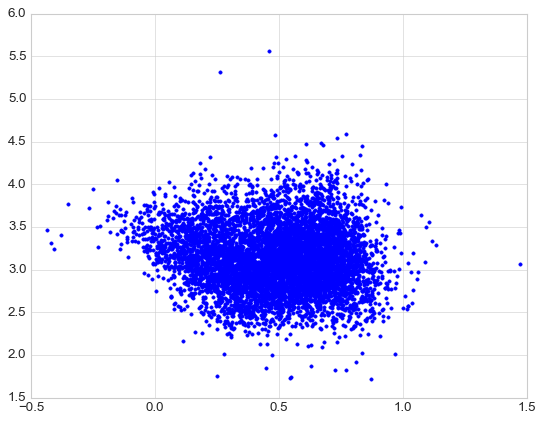

In [222]:
plt.plot(merged_df_filtered_SN2['color_gr'],merged_df_filtered_SN2['h_alpha_flux_int'], '.')

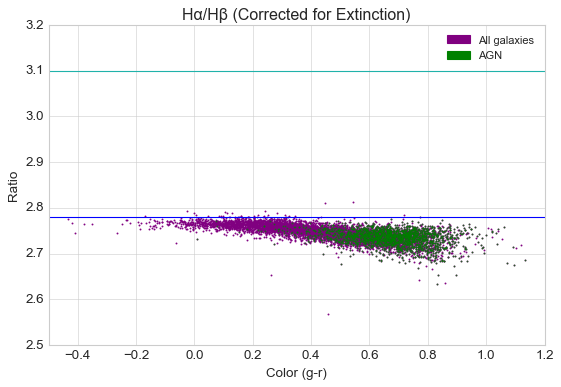

In [223]:
#Hα/Hβ
plt.figure(figsize=(8, 5))
plt.scatter(merged_df_filtered_SN2['color_gr'], 
            (merged_df_filtered_SN2['ratio_Hα/Hβ_corrected']), 
            s=0.5, color='purple', label='Todas las galaxias')
plt.scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            (merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'ratio_Hα/Hβ_corrected']), 
            s=0.5, alpha=0.6, color='green', label='AGN')
plt.axhline(y = 2.78, color = 'blue', linestyle = '-') 
plt.axhline(y = 3.1, color = 'lightseagreen', linestyle = '-') 

legend_handles = [mpatches.Patch(color='purple', label='All galaxies'),
                  mpatches.Patch(color='green', label='AGN')]

plt.xlim(-0.5, 1.2)
plt.title('Hα/Hβ (Corrected for Extinction)')
plt.xlabel('Color (g-r)')
plt.ylabel('Ratio')
plt.legend(handles=legend_handles, loc='upper right', prop={'size': 10})


(2.6645402116030854, 14.41040814580796)

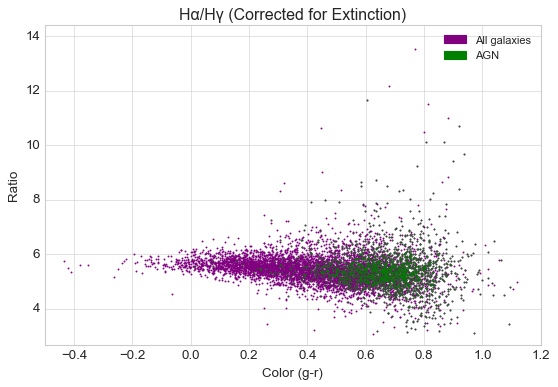

In [224]:
plt.figure(figsize=(8, 5))
plt.scatter(merged_df_filtered_SN2['color_gr'], 
            merged_df_filtered_SN2['ratio_Hα/Hγ_corrected'], 
            s=0.5, color='purple', label='Todas las galaxias')
plt.scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'ratio_Hα/Hγ_corrected'], 
            s=0.5, alpha=0.6, color='green', label='AGN')

# Labels and title
plt.title('Hα/Hγ (Corrected for Extinction)')
plt.xlabel('Color (g-r)')
plt.ylabel('Ratio')
plt.ylim(-1, 15)
plt.xlim(-0.5, 1.2)

legend_handles = [mpatches.Patch(color='purple', label='All galaxies'),
                  mpatches.Patch(color='green', label='AGN')]

plt.legend(handles=legend_handles, loc='upper right', prop={'size': 10})
p5, p95 = np.nanpercentile(merged_df_filtered_SN2['ratio_Hα/Hγ_corrected'], [0.5, 99.9])

plt.ylim(p5 - 0.1 * (p95 - p5), p95 + 0.1 * (p95 - p5))  



(2.0566031525976856, 38.36464900038327)

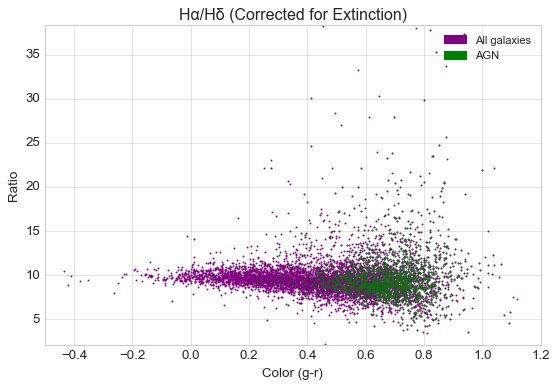

In [225]:
plt.figure(figsize=(8, 5))
plt.scatter(merged_df_filtered_SN2['color_gr'], 
            merged_df_filtered_SN2['ratio_Hα/Hδ_corrected'], 
            s=0.5, color='purple', label='Todas las galaxias')
plt.scatter(merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'color_gr'], 
            merged_df_filtered_SN2.loc[merged_df_filtered_SN2['AGN_BPT-NII'] == True, 'ratio_Hα/Hδ_corrected'], 
            s=0.5, alpha=0.6, color='green', label='AGN')

# Labels and title
plt.title('Hα/Hδ (Corrected for Extinction)')
plt.xlabel('Color (g-r)')
plt.ylabel('Ratio')
plt.ylim(0, 40)

legend_handles = [mpatches.Patch(color='purple', label='All galaxies'),
                  mpatches.Patch(color='green', label='AGN')]

plt.legend(handles=legend_handles, loc='upper right', prop={'size': 10})
p5, p95 = np.nanpercentile(merged_df_filtered_SN2['ratio_Hα/Hδ_corrected'], [0.5, 99.6])
plt.xlim(-0.5, 1.2)
plt.ylim(p5 - 0.1 * (p95 - p5), p95 + 0.1 * (p95 - p5))  



In [219]:
alpha_beta = (np.log10(df_galaxies_SN2['ratio_Hα/Hβ'])-np.log10(merged_df_filtered_SN2['ratio_Hα/Hβ_corrected']))
alpha_gamma = (np.log10(df_galaxies_SN2['ratio_Hγ/Hα']**(-1))-np.log10(merged_df_filtered_SN2['ratio_Hα/Hγ_corrected']))
alpha_delta = (np.log10(df_galaxies_SN2['ratio_Hδ/Hα']**(-1))-np.log10(merged_df_filtered_SN2['ratio_Hα/Hδ_corrected']))


In [128]:
alpha_beta = np.array(alpha_beta)
alpha_gamma = np.array(alpha_gamma)
alpha_delta = np.array(alpha_delta)

def get_iqr_mask(data):
    Q1, Q3 = np.nanpercentile(data, [15, 85])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data >= lower_bound) & (data <= upper_bound)

mask_beta = get_iqr_mask(alpha_beta)
mask_gamma = get_iqr_mask(alpha_gamma)
mask_delta = get_iqr_mask(alpha_delta)

alpha_beta_filtered = alpha_beta[mask_beta]
alpha_gamma_filtered = alpha_gamma[mask_gamma]
alpha_delta_filtered = alpha_delta[mask_delta]

alpha_beta_filtered = alpha_beta_filtered[0:6930]
alpha_gamma_filtered = alpha_gamma_filtered[0:6930]
alpha_delta_filtered = alpha_delta_filtered[0:6930]

m_gamma, b_gamma = np.polyfit(alpha_beta_filtered, alpha_gamma_filtered, 1)
m_delta, b_delta = np.polyfit(alpha_beta_filtered, alpha_delta_filtered, 1)


In [129]:
len(alpha_beta_filtered)
#len(alpha_gamma_filtered) 
#len(alpha_delta_filtered)


6930

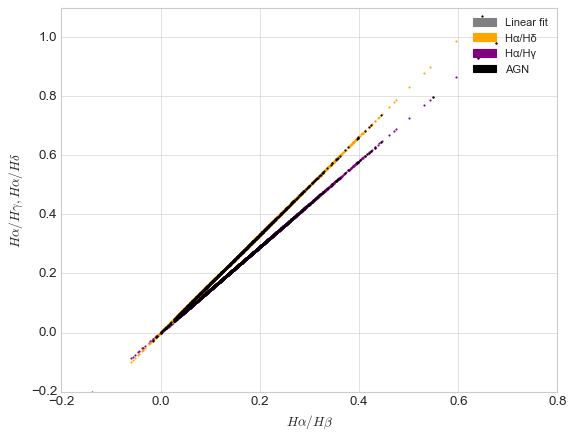

In [194]:
#m_gamma, b_gamma = np.polyfit(alpha_beta, alpha_gamma, 1)  
#m_delta, b_delta = np.polyfit(alpha_beta, alpha_delta, 1)  

plt.scatter(alpha_beta, alpha_gamma, s=0.8, color='purple', label='Hα/Hγ vs. Hα/Hβ')
plt.scatter(alpha_beta, alpha_delta, s=0.8, color='orange', label='Hα/Hδ vs. Hα/Hβ')
plt.scatter(alpha_beta[merged_df_filtered_SN2['AGN']==True], alpha_delta[merged_df_filtered_SN2['AGN']==True], s=0.8, color='black', label='AGN')
plt.scatter(alpha_beta[merged_df_filtered_SN2['AGN']==True], alpha_gamma[merged_df_filtered_SN2['AGN']==True], s=0.8, color='black', label='AGN')

x_range = np.linspace(0, 10, 100)  # Generate x values for smooth line
#plt.plot(x_range, m_gamma*x_range + b_gamma, color='black',  label=f'Fit: Hα/Hγ = {m_gamma:.2f}Hα/Hβ + {b_gamma:.2f}')
#plt.plot(x_range, m_delta*x_range + b_delta, color='black',  label=f'Fit: Hα/Hδ = {m_delta:.2f}Hα/Hβ + {b_delta:.2f}')

#plt.plot(alpha_beta, 3.30*alpha_beta, color='grey', label='Linear fit')
#plt.plot(alpha_beta, 7.05*alpha_beta, color='grey')
legend_handles = [mpatches.Patch(color='grey', label='Linear fit'),
                  mpatches.Patch(color='orange', label='Hα/Hδ '), 
                  mpatches.Patch(color='purple', label='Hα/Hγ '),
                  mpatches.Patch(color='black', label='AGN')]

plt.ylim(-0.2, 1.1)
plt.xlim(-0.2, 0.8)
plt.xlabel(r'$H\alpha/H{\beta}$')
plt.ylabel(r'$H\alpha/H{\gamma}, H\alpha/H{\delta}$')
plt.legend(handles=legend_handles, loc='upper right', prop={'size': 10})
plt.show()

(0.0, 80.0)

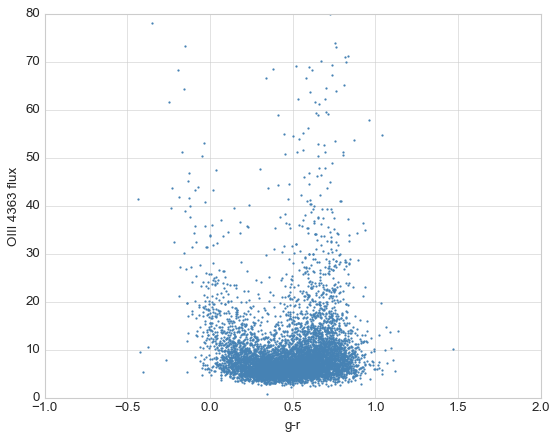

In [52]:
plt.scatter(merged_df_filtered_SN2['color_gr'], merged_df_filtered_SN2['oiii_4363_flux'], s=1, alpha=1, color='steelblue')
plt.ylabel('OIII 4363 flux')
plt.xlabel('g-r')
plt.ylim(0,80)